In [1]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from patsy import dmatrices
import statsmodels.api as sm
from copy import deepcopy

In [2]:
org_data = pd.read_pickle(r'data_org.pkl')
p_matched = pd.read_pickle(r'processed_matched.pkl')

In [3]:
# Handling missing values
org_data['income'].fillna(71, inplace=True)
org_data['loan_to_value_ratio'].fillna(93, inplace=True)
org_data['debt_to_income_ratio'].fillna(41, inplace=True)
p_matched['income'].fillna(56, inplace=True)
p_matched['loan_to_value_ratio'].fillna(93, inplace=True)
p_matched['debt_to_income_ratio'].fillna(44, inplace=True)

## Approval

In [4]:
org_data = org_data.dropna(subset=['action_taken','applicant_sex','income','applicant_race', 
                                   'debt_to_income_ratio', 'loan_to_value_ratio', 'lien_status'])
X_rf = org_data[['applicant_race', 'debt_to_income_ratio', 'loan_to_value_ratio', 'lien_status']]
X_rf['log_income'] = np.log(org_data['income'])
sex = pd.get_dummies(org_data['applicant_sex'], drop_first=True, prefix='sex')
X_rf[sex.columns] = sex
y_rf = org_data['action_taken']

<ipython-input-4-2feef29930d5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_rf['log_income'] = np.log(org_data['income'])
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [5]:
print(X_rf.shape)
print(y_rf.shape)

(3185334, 8)
(3185334,)


### Algorithm 1: Use all features and train an RF on *Original data*

In [6]:
clf_rf1 = RandomForestClassifier(random_state=0)
clf_rf1.fit(X_rf, y_rf)

RandomForestClassifier(random_state=0)

### Algorithm 2: Don't use *Race* and train another RF on *Original data*

In [7]:
X_rf2 = X_rf
X_rf2['applicant_race']=0

<ipython-input-7-7da77956defe>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_rf2['applicant_race']=0


In [8]:
clf_rf2 = RandomForestClassifier(random_state=0)
clf_rf2.fit(X_rf2, y_rf)

RandomForestClassifier(random_state=0)

### Algorithm 3: Don't use *Race* and train another RF on *Matched Data*

In [9]:
matched = p_matched[['action_taken', 'applicant_race', 'debt_to_income_ratio', 'loan_to_value_ratio', 'lien_status']]
matched['log_income'] = np.log(p_matched['income'])
sex = pd.get_dummies(p_matched['applicant_sex'], drop_first=True, prefix='sex')
matched[sex.columns] = sex

<ipython-input-9-61d33da0cc50>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched['log_income'] = np.log(p_matched['income'])
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [10]:
# extract B and W in Matched data and remove pairs that have NaNs.
matched_b = matched.iloc[0::2, :]
matched_w = matched.iloc[1::2, :]
drop_index = list(set(np.where(pd.isna(matched_w).sum(axis=1).values>0)[0]) | set(np.where(pd.isna(matched_b).sum(axis=1).values>0)[0]))
matched_w = matched_w.drop(index=matched_w.index[drop_index])
matched_b = matched_b.drop(index=matched_b.index[drop_index])
matched_new = pd.concat((matched_w, matched_b))

In [11]:
n_w = matched_w.shape[0]
n_b = matched_b.shape[0]

In [ ]:
matched_new.iloc[[1, n_w+1], :]

In [12]:
X_rf_matched = matched_new[['applicant_race', 'debt_to_income_ratio', 'loan_to_value_ratio', 
                     'lien_status','log_income','sex_2','sex_3','sex_6']]
X_rf3 = deepcopy(X_rf_matched)
X_rf3['applicant_race']=0
y_rf3 = matched_new[['action_taken']]


In [13]:
clf_rf3 = RandomForestClassifier(random_state=0)
clf_rf3.fit(X_rf3, y_rf3)

<ipython-input-13-0139d744f6e2>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf_rf3.fit(X_rf3, y_rf3)


RandomForestClassifier(random_state=0)

In [ ]:
X_rf_matched

### predicting approval probability using algorithms 1,2,3 

In [14]:
pred1 = clf_rf1.predict_proba(X_rf_matched)[:, 1]

In [15]:
pred2 = clf_rf2.predict_proba(X_rf_matched)[:, 1]

In [16]:
pred3 = clf_rf3.predict_proba(X_rf_matched)[:, 1]

### plotting the histogram of approval probabilities for algorithm 1

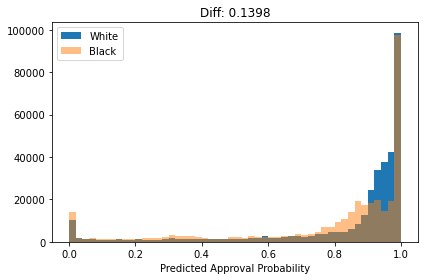

In [17]:
plt.hist(pred1[:n_w],bins=50)
plt.hist(pred1[n_w:],bins=50,alpha=0.5)
diff = (abs(pred1[:n_w]-pred1[n_w:])).mean()
plt.legend(['White', 'Black'])
plt.xlabel('Predicted Approval Probability')
plt.title(f'Diff: {diff:.4f}')
plt.tight_layout()
plt.savefig('Approval_RF1.pdf')

### plotting the histogram of approval probabilities for algorithm 2

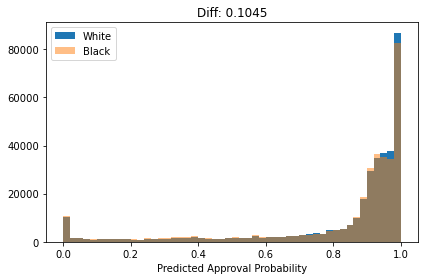

In [18]:
plt.hist(pred2[:n_w],bins=50)
plt.hist(pred2[n_w:],bins=50,alpha=0.5)
diff = (abs(pred2[:n_w]-pred2[n_w:])).mean()
plt.legend(['White', 'Black'])
plt.xlabel('Predicted Approval Probability')
plt.title(f'Diff: {diff:.4f}')
plt.tight_layout()
plt.savefig('Approval_RF2.pdf')

### plotting the histogram of approval probabilities for algorithm 3

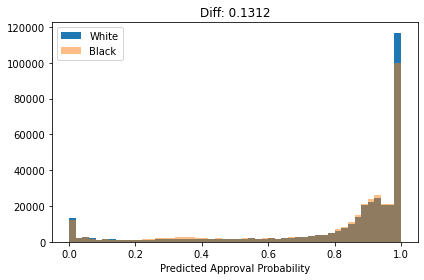

In [19]:
plt.hist(pred3[:n_w],bins=50)
plt.hist(pred3[n_w:],bins=50,alpha=0.5)
diff = (abs(pred3[:n_w]-pred3[n_w:])).mean()
plt.legend(['White', 'Black'])
plt.xlabel('Predicted Approval Probability')
plt.title(f'Diff: {diff:.4f}')
plt.tight_layout()
plt.savefig('Approval_RF3.pdf')